# TMDB5000 - The Importance of Cross Validation in evaluating a model's performance. 

In [418]:
import numpy as np
import pandas as pd

movie_df = pd.read_csv("/kaggle/input/tmdb_5000_movies.csv")
movie_df.head()

# ===== Columns I'd like to use (6 attributes/cols): 
# -- Budget, 
# -- Genres             --- > (will be split up i.e. each genre will be a col), 
# -- Original language, --- > len(movie_df["original_language"].unique()) yields 37  
# -- Popularity, 
# -- Vote_average, 
# -- Vote_count 
# ===== Label: 
# -- Revenue (I will assume that it's already in dollars $)
movie_df = movie_df[["budget", "genres", "original_language", "popularity", "vote_average", "vote_count", "revenue"]]

# Looking for missing data. 
print(movie_df.info())

# Dropping na values.
movie_df.dropna(inplace=True)
movie_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 7 columns):
budget               4803 non-null int64
genres               4803 non-null object
original_language    4803 non-null object
popularity           4803 non-null float64
vote_average         4803 non-null float64
vote_count           4803 non-null int64
revenue              4803 non-null int64
dtypes: float64(2), int64(3), object(2)
memory usage: 262.8+ KB
None


,budget,genres,original_language,popularity,vote_average,vote_count,revenue
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",en,150.437577,7.2,11800,2787965087
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",en,139.082615,6.9,4500,961000000
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",en,107.376788,6.3,4466,880674609
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",en,112.312950,7.6,9106,1084939099
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",en,43.926995,6.1,2124,284139100


In [419]:
from sklearn.model_selection import train_test_split
train_set,test_set = train_test_split(movie_df, test_size=0.2, random_state=42)
# I will apply stratified shuffling in another kernel to demonstrate the difference
# when splitting a ds in training and testing sets.
movie_df = train_set.copy()

In [420]:
# Let's preprocess some attributes.
# Getting the unique genres and preprocessing them.

# Dropping rows with na values.
movie_df.dropna(axis=0, inplace=True)
# Reset index so that I can properly concat the zero matrix to 'movie_df' and
# dropping the old index
movie_df.reset_index(inplace=True)
movie_df.drop("index", axis=1, inplace=True)

genres = []
import json
def extractGenre(item):
    json_obj = json.loads(item) 
    for item in json_obj:
        if item["name"] not in genres:
            genres.append(item["name"])

            
print(movie_df.shape)
movie_df["genres"].apply(lambda x: extractGenre(x))
print(f"The original movie_df has {movie_df.shape[0]} rows.")
print(f"The zero_matrix has {movie_df.shape[0]} rows and {len(genres)} columns.")
zero_matrix = pd.DataFrame(0, index=np.arange(movie_df.shape[0]), columns=genres)
print(f"{zero_matrix.shape[1]} new columns/atts were added to the dataset (Action, Thriller, etc).")
movie_df = pd.concat([movie_df, zero_matrix], axis=1)

# 6 original atts + 1 label + 20 genres = 27 cols/atts.
print(f"Now, the main df's shape is: {movie_df.shape}")

(3842, 7)
The original movie_df has 3842 rows.
The zero_matrix has 3842 rows and 20 columns.
20 new columns/atts were added to the dataset (Action, Thriller, etc).
Now, the main df's shape is: (3842, 27)


In [421]:
# Creating columns to each of the genres and appending them to the
# dataset I'll be using.
for row in movie_df.itertuples():
    row_dict = row._asdict()
    row_ix = row_dict["Index"]
    if isinstance(row_dict["genres"], float): # nan.
        # Dropping rows with nan values I found on the genres col.
        movie_df.drop(row_ix, inplace=True)
    else:
        json_obj = json.loads(row_dict["genres"])
        current_genres = []
        for genre in json_obj:
            current_genres.append(genre["name"])
        movie_df.loc[row_ix, current_genres] = 1
        
movie_df = movie_df.drop("genres", axis=1) # Now: 26 columns.

In [422]:
# Let's deal with categorical attributes.
cat_atts = ["original_language"]

# Transformer pipeline: dfselector -> label binarizer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, LabelBinarizer

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.attribute_names].values

class MyLabelBinarizer(TransformerMixin):
    def __init__(self):
        self.encoder = LabelBinarizer()
    
    def fit(self, X, y=None):
        self.encoder.fit(X)
        return self

    def transform(self, X, y=None):
        return self.encoder.transform(X)

cat_pipeline = Pipeline([
    ("df_selector", DataFrameSelector(cat_atts)),
    ("label_binarizer", MyLabelBinarizer()),
])

In [423]:
# Creating pipeline for the numerical attributes so that I can
# scale them. They have far too many different types of scales.
# Transformer pipeline: dfselector -> scaler
num_atts = list(movie_df.drop(["original_language", "revenue"], axis=1).columns)
print(num_atts)
num_pipeline = Pipeline([
    ("df_selector", DataFrameSelector(num_atts)),
    ("std_scaler", StandardScaler()),
])

['budget', 'popularity', 'vote_average', 'vote_count', 'Comedy', 'Drama', 'Romance', 'Music', 'Action', 'Thriller', 'Adventure', 'Fantasy', 'Mystery', 'Crime', 'Family', 'Science Fiction', 'War', 'History', 'Horror', 'Animation', 'Documentary', 'Western', 'Foreign', 'TV Movie']


In [424]:
# Running both pipelines to prepare num and cat atts.
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion([
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline)
])
predictors_df = movie_df.drop("revenue", axis=1) # 25 predictors/cols
movie_df_prepared = full_pipeline.fit_transform(predictors_df)

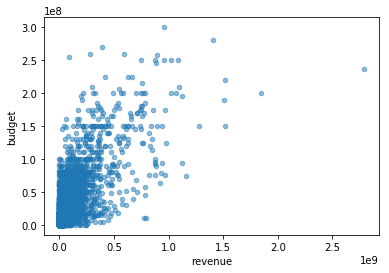

In [425]:
# Checking if there are any attributes that are deeply correlated with the revenue
# so that I can apply stratified shuffling later based on this attribute.
corr_matrix = movie_df.corr()
corr_matrix["revenue"]
# The budget seems to have a nice correlation with the revenue. Let's plot it to have a visual
# representation of it.
movie_df.plot(kind="scatter", x="revenue", y="budget", alpha=0.5)

In [426]:
# Getting the target att (label).
df_label = movie_df["revenue"]

In [427]:
# Training the model with the Decision Tree Regressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
dtree_regressor = DecisionTreeRegressor()
dtree_regressor.fit(movie_df_prepared, df_label)
predictions = dtree_regressor.predict(movie_df_prepared)
dtree_mse = mean_squared_error(df_label, predictions)
dtree_rmse = np.sqrt(dtree_mse)
dtree_rmse

0.0

In [428]:
# Use cross validation to discover an overfitting model.
from sklearn.model_selection import cross_val_score
dtree_cv_mse_scores = cross_val_score(dtree_regressor, movie_df_prepared, df_label, scoring="neg_mean_squared_error", cv=10)
dtree_cv_rmse_scores = np.sqrt(-dtree_cv_mse_scores)
print(f"RMSEs: {dtree_cv_rmse_scores}")
print(f"Average RMSE: {dtree_cv_rmse_scores.mean()}")

RMSEs: [1.22897031e+08 9.26478800e+07 1.26865339e+08 1.28131831e+08
 9.97401401e+07 9.79618041e+07 1.25210695e+08 9.47606568e+07
 1.11249821e+08 1.29852584e+08]
Average RMSE: 112931778.22701295


### As you can see, simply measuring a model's performance through RMSE is not enough. Our Decision Tree model yields an RMSE of 0 (which leads me to assume that this model is hugely overfitting the data it was trained on). However, when I use cross validation, I uncover some new facts about the trained model. It shows an average RMSE ~113 million dollars (which, of course, if a very poorly trained model).

### This exercise was just to demonstrate the importance of using cross validation when evaluating a model's performance.